In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy import stats
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, kstest, monte_carlo_test, norm
from scipy.stats import boxcox
from numpy import mean, var, sqrt


In [2]:
df = pd.read_csv("/kaggle/input/reddit-perspective/comments_scores.csv")

/tmp/ipykernel_33/2330801559.py:1: DtypeWarning: Columns (6,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/reddit-perspective/comments_scores.csv")


In [3]:
row = df[df['id'] =="ehr19l2"]
print(row['body'].values[0])

No just the racist fascist pieces of shit that support [NAME].Fucking Nazis have no idea what fascist means or Fucking Nazis know and Fucking Nazis don't care. 


In [4]:
df.iloc[1]["body"]

'Just wait til [NAME] releases [NAME] tapes! ...probably via Emin music video.'

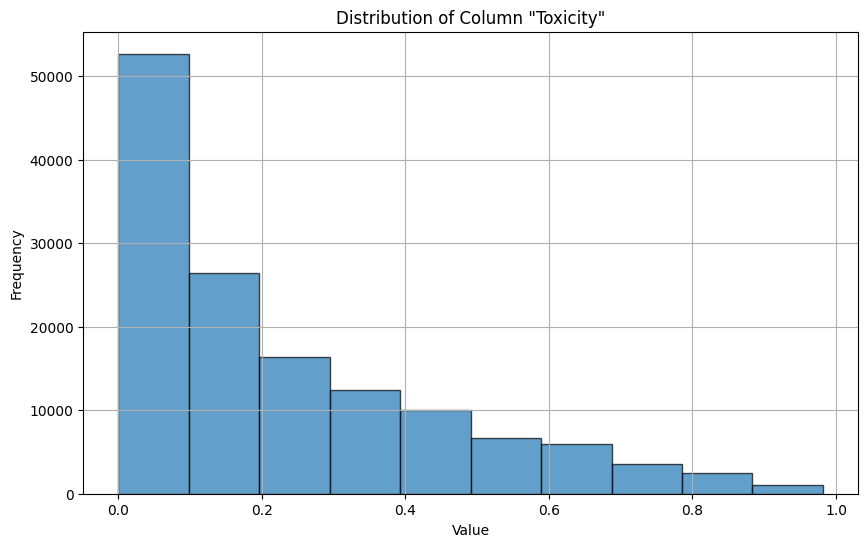

In [5]:
# Plotting the distribution of column 'a'
plt.figure(figsize=(10, 6))
plt.hist(df['toxicity'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of Column "Toxicity"')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

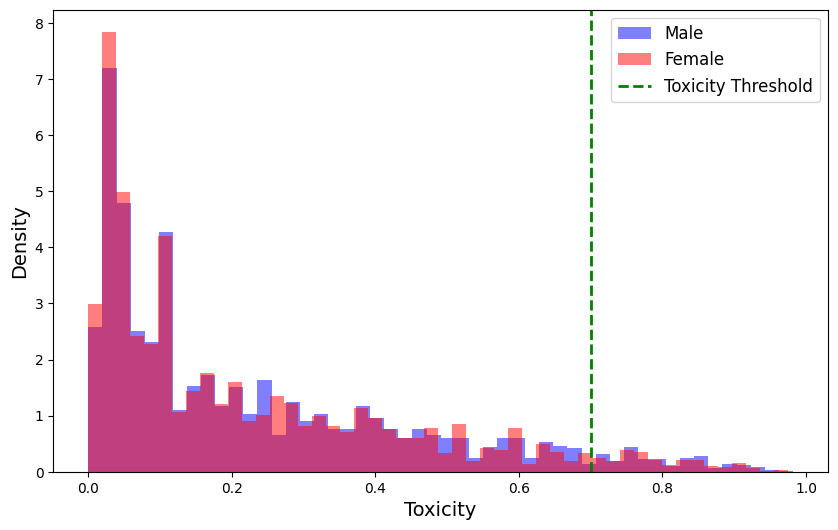

In [6]:
# Splitting the data into two groups based on 'sex'
male_toxicity = df[df['sex'] == 'male']['toxicity']
female_toxicity = df[df['sex'] == 'female']['toxicity']

plt.figure(figsize=(10, 6))

plt.hist(male_toxicity, bins=50, alpha=0.5, label='Male', color='blue', density=True)
plt.hist(female_toxicity, bins=50, alpha=0.5, label='Female', color='red', density=True)

# Adding the threshold line at 0.7
plt.axvline(x=0.7, color='green', linestyle='--', linewidth=2, label='Toxicity Threshold')

plt.xlabel('Toxicity', fontsize=14)
plt.ylabel('Density', fontsize=14)
#plt.title('Toxicity Distribution by Sex', fontsize=16)
plt.legend(loc='upper right', fontsize=12)

plt.savefig("hist.png")
plt.show()

In [7]:
# Log normalize the toxicity scores, adding a small constant to avoid log(0)
df['log_toxicity'] = np.log(df['toxicity'] + 1e-9)

# Remove any NaN or infinite values from log_toxicity
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_toxicity'])


# Separate the log-normalized scores by sex
male_log_toxicity = df[df['sex'] == 'male']['log_toxicity']
female_log_toxicity = df[df['sex'] == 'female']['log_toxicity']

# Perform an independent two-sample t-test
t_stat, p_value = ttest_ind(male_log_toxicity, female_log_toxicity)

# Calculate Cohen's d
n1, n2 = len(male_log_toxicity), len(female_log_toxicity)
mean1, mean2 = mean(male_log_toxicity), mean(female_log_toxicity)
var1, var2 = np.var(male_log_toxicity, ddof=1), np.var(female_log_toxicity, ddof=1)
pooled_std = sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
cohens_d = (mean1 - mean2) / pooled_std

# Perform the Mann-Whitney U test on the means without log transformation
male_toxicity = df[df['sex'] == 'male']['toxicity'].dropna()
female_toxicity = df[df['sex'] == 'female']['toxicity'].dropna()

u_stat, u_p_value = mannwhitneyu(male_toxicity, female_toxicity)

# Test if the log-transformed column is normally distributed
stat, p = shapiro(df['log_toxicity'])

print('Shapiro Statistics=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
   
# Monte Carlo approximation for Shapiro-Wilk test p-value using scipy.stats.monte_carlo_test
def shapiro_statistic(x):
    return shapiro(x)[0]



res = monte_carlo_test(df['log_toxicity'], rvs=lambda size: norm.rvs(size=size), statistic=shapiro_statistic, vectorized=False)

# Display the results
print(f"T-statistic: {t_stat}, P-value: {p_value}")
print(f"Cohen's d: {cohens_d}")
print(f"U-statistic: {u_stat}, U P-value: {u_p_value}")
print(f"Shapiro-Wilk test statistic: {stat}, p-value: {p}")
print(f"Monte Carlo approximated p-value for Shapiro-Wilk test: {res.pvalue}")

/opt/conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro Statistics=0.964, p=0.000
Sample does not look Gaussian (reject H0)
T-statistic: 7.051022563645225, P-value: 1.7843922608086512e-12
Cohen's d: 0.056486833859799954
U-statistic: 1105051493.0, U P-value: 1.3664322538866495e-11
Shapiro-Wilk test statistic: 0.9642361998558044, p-value: 0.0
Monte Carlo approximated p-value for Shapiro-Wilk test: 0.0002


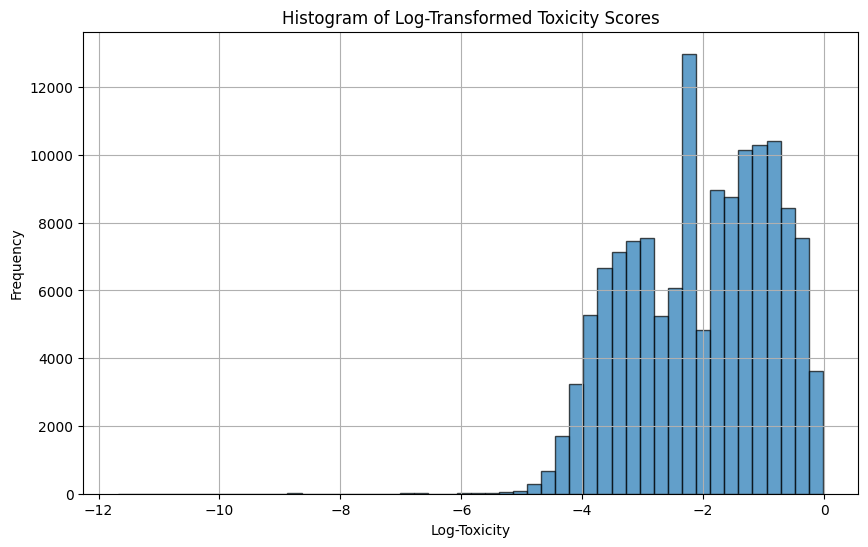

In [8]:
# Plotting the histogram of the log-transformed toxicity scores
plt.figure(figsize=(10, 6))
plt.hist(df['log_toxicity'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Histogram of Log-Transformed Toxicity Scores')
plt.xlabel('Log-Toxicity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

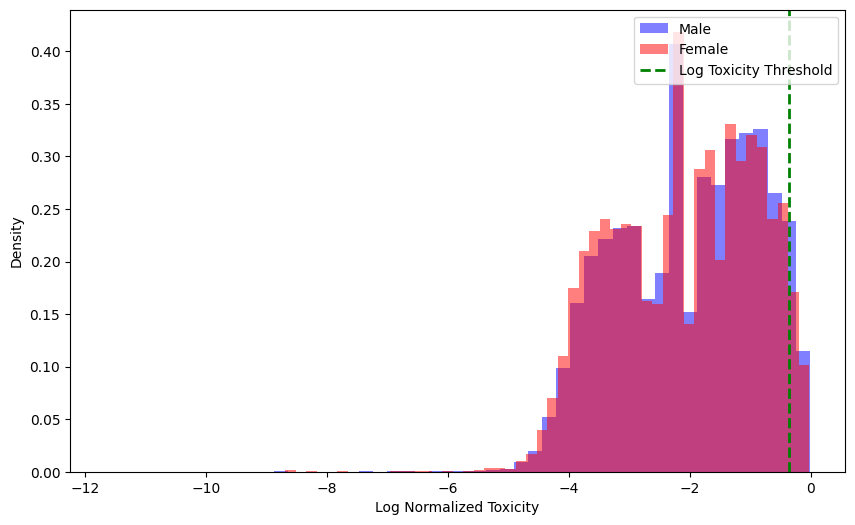

In [9]:
# Plotting the histograms of log-normalized toxicity scores with the threshold line at log(0.7)
plt.figure(figsize=(10, 6))

plt.hist(male_log_toxicity, bins=50, alpha=0.5, label='Male', color='blue', density=True)
plt.hist(female_log_toxicity, bins=50, alpha=0.5, label='Female', color='red', density=True)

# Adding the threshold line at log(0.7)
threshold = np.log(0.7 + 1e-9)
plt.axvline(x=threshold, color='green', linestyle='--', linewidth=2, label='Log Toxicity Threshold')

plt.xlabel('Log Normalized Toxicity')
plt.ylabel('Density')
#plt.title('Log Normalized Toxicity Distribution by Sex')
plt.legend(loc='upper right')

plt.show()

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Non-log transformed toxicity scores
male_toxicity = df[df['sex'] == 'male']['toxicity'].dropna()
female_toxicity = df[df['sex'] == 'female']['toxicity'].dropna()

# Calculate the means of the non-log transformed toxicity scores for males and females
mean_male_toxicity = male_toxicity.mean()
mean_female_toxicity = female_toxicity.mean()

# Bootstrap confidence intervals for each group
def bootstrap_confidence_interval(data, n_iterations=10000):
    bootstrapped_means = []
    for _ in range(n_iterations):
        resampled_data = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(resampled_data.mean())
    return np.percentile(bootstrapped_means, [2.5, 97.5])

ci_male = bootstrap_confidence_interval(male_toxicity)
ci_female = bootstrap_confidence_interval(female_toxicity)

# Bootstrap the difference in means
def bootstrap_mean_difference(data1, data2, n_iterations=10000):
    bootstrapped_differences = []
    n1, n2 = len(data1), len(data2)

    for _ in range(n_iterations):
        resampled_data1 = np.random.choice(data1, size=n1, replace=True)
        resampled_data2 = np.random.choice(data2, size=n2, replace=True)
        bootstrapped_differences.append(resampled_data2.mean() - resampled_data1.mean())
    
    return np.percentile(bootstrapped_differences, [2.5, 97.5]), np.mean(bootstrapped_differences)

# Perform bootstrap for the difference in means
confidence_interval_diff, bootstrap_mean_diff = bootstrap_mean_difference(male_toxicity.values, female_toxicity.values)


# Means and confidence intervals
means = [mean_male_toxicity, mean_female_toxicity]
ci_low = [mean_male_toxicity - ci_male[0], mean_female_toxicity - ci_female[0]]
ci_high = [ci_male[1] - mean_male_toxicity, ci_female[1] - mean_female_toxicity]


# Print the results with text
print(f"Mean toxicity score for males: {mean_male_toxicity:.2f}")
print(f"95% Confidence Interval for males: [{ci_male[0]:.2f}, {ci_male[1]:.2f}]")

print(f"Mean toxicity score for females: {mean_female_toxicity:.2f}")
print(f"95% Confidence Interval for females: [{ci_female[0]:.2f}, {ci_female[1]:.2f}]")

print(f"Mean difference in toxicity scores (female - male): {bootstrap_mean_diff:.2f}")
print(f"95% Confidence Interval for the mean difference: [{confidence_interval_diff[0]:.2f}, {confidence_interval_diff[1]:.2f}]")



Mean toxicity score for males: 0.23
95% Confidence Interval for males: [0.23, 0.23]
Mean toxicity score for females: 0.22
95% Confidence Interval for females: [0.22, 0.22]
Mean difference in toxicity scores (female - male): -0.01
95% Confidence Interval for the mean difference: [-0.01, -0.01]


In [11]:
# Assuming df is already defined and contains the 'toxicity' and 'sex' columns
threshold = 0.7
df['is_toxic'] = df['toxicity'] > threshold
df = df[df['sex'].isin(['male', 'female'])]

# Count the number of toxic comments per group
toxic_counts = df.groupby('sex')['is_toxic'].sum()
total_counts = df.groupby('sex')['is_toxic'].count()

# Calculate the ratio of toxic comments to all comments in each group
ratio_toxic = toxic_counts / total_counts

# Bootstrap to calculate 95% confidence intervals for the ratio of toxic comments
def bootstrap_ratio(data, group_col, value_col, n_bootstrap=1000, ci=95):
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        boot_sample = data.sample(frac=1, replace=True)
        grouped = boot_sample.groupby(group_col)[value_col].mean()
        bootstrapped_means.append(grouped)
    bootstrapped_means = pd.DataFrame(bootstrapped_means)
    ci_lower = np.percentile(bootstrapped_means, (100-ci)/2, axis=0)
    ci_upper = np.percentile(bootstrapped_means, 100-(100-ci)/2, axis=0)
    return pd.DataFrame({'lower_ci': ci_lower, 'upper_ci': ci_upper}, index=bootstrapped_means.columns)

# Calculate confidence intervals
ci_intervals = bootstrap_ratio(df, 'sex', 'is_toxic')



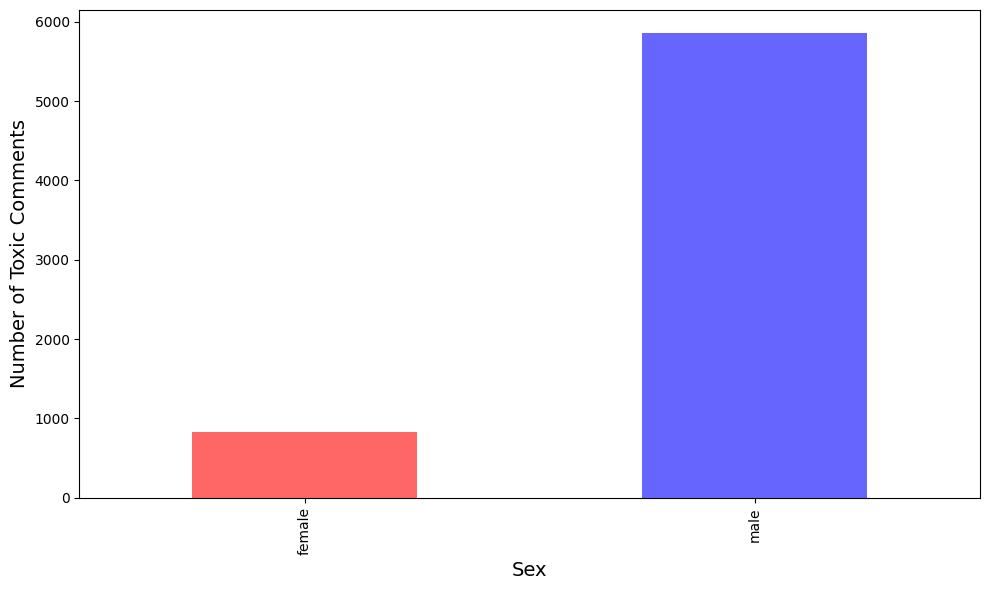

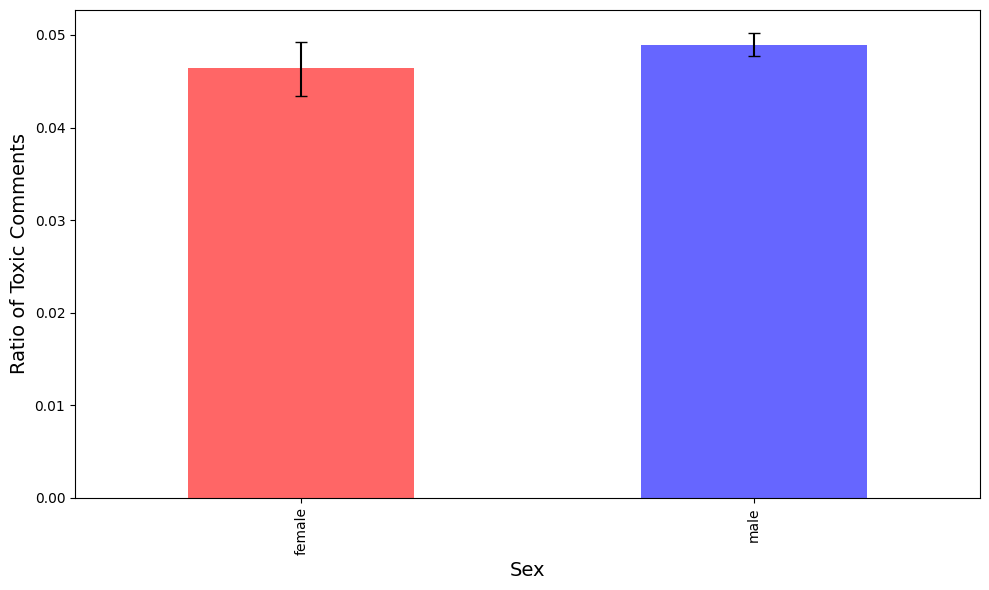

In [12]:
# Plot the counts of toxic comments per group
plt.figure(figsize=(10, 6))
toxic_counts.plot(kind='bar', color=['red', 'blue'], alpha=0.6)
plt.xlabel('Sex', fontsize=14)
plt.ylabel('Number of Toxic Comments', fontsize=14)
#plt.title('Number of Toxic Comments by Sex', fontsize=16)
plt.tight_layout() 
plt.savefig("toxicity_total.png")
plt.show()

# Plot the ratio of toxic comments to all comments in each group with confidence intervals
plt.figure(figsize=(10, 6))
ax = ratio_toxic.plot(kind='bar', color=['red', 'blue'], alpha=0.6, yerr=[ratio_toxic - ci_intervals['lower_ci'], ci_intervals['upper_ci'] - ratio_toxic], capsize=4)
plt.xlabel('Sex', fontsize=14)
plt.ylabel('Ratio of Toxic Comments', fontsize=14)
#plt.title('Ratio of Toxic Comments to All Comments by Sex', fontsize=16)
plt.tight_layout() 
plt.savefig("toxicity_ratio.png")
plt.show()

In [13]:
df[df['toxicity'] > threshold]

,id,body,subreddit,to_type,NEL,Names,created_utc,sex,ethnicity,origin,...,Arousal,Dominance,insult,profanity,threat,severe_toxicity,identity_attack,toxicity,log_toxicity,is_toxic
41,e2taydy,Keep letting perfection be the enemy of good. ...,politics,t1,Q22686,['Trump'],NaN,male,NaN,United States of America,...,0.522925,0.561850,0.651296,0.844891,0.082431,0.447873,0.276629,0.853334,-0.158604,True
64,e1scupa,Breaking news: [NAME] remains full of shit. Mo...,politics,t3,Q212648,['Guiliani'],NaN,male,NaN,United States of America,...,0.410600,0.517600,0.496273,0.767348,0.018365,0.169603,0.091628,0.788558,-0.237549,True
65,e1sdcqq,"I try my best to empathize with everyone, even...",politics,t1,Q7437083,['Pruitt'],NaN,male,NaN,United States of America,...,0.476000,0.539750,0.679858,0.880201,0.519571,0.458954,0.228595,0.862967,-0.147379,True
98,e2y5prv,not to mention shit like this that just droppe...,politics,t3,Q463557,['Rand Paul'],NaN,male,NaN,United States of America,...,0.513931,0.622352,0.489133,0.652821,0.079364,0.350942,0.490746,0.725297,-0.321174,True
102,e2y7c6t,Alex Jones may be a bigger “fucking moron” tha...,politics,t3,Q22686,['Donald'],NaN,male,NaN,United States of America,...,0.442400,0.357400,0.839438,0.890795,0.011742,0.458954,0.180029,0.924899,-0.078070,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137414,faljimu,FUCK YES THANK YOU[NAME] + corruption is the s...,politics,t3,Q22686,['Trump'],NaN,male,NaN,United States of America,...,0.134833,0.118111,0.434504,0.839747,0.037185,0.451856,0.097418,0.854047,-0.157769,True
137422,fclg700,"Fuck you, folks who are homeless aren't a talk...",politics,t3,Q22686,['Trump'],NaN,male,NaN,United States of America,...,0.114367,0.088490,0.729812,0.934264,0.064969,0.507037,0.550447,0.960691,-0.040102,True
137468,fbcxyoc,How does anyone believe the narrative that [NA...,politics,t1,Q22686,['Trump'],NaN,male,NaN,United States of America,...,0.142300,0.143950,0.785655,0.495769,0.009049,0.024115,0.064768,0.820483,-0.197863,True
137516,f9njuja,"[NAME]: ""I watched Hannity, Laura Ingraham, an...",politics,t3,Q22686,['Trump'],NaN,male,NaN,United States of America,...,0.121583,0.124167,0.711202,0.808958,0.011612,0.351302,0.091628,0.851736,-0.160479,True


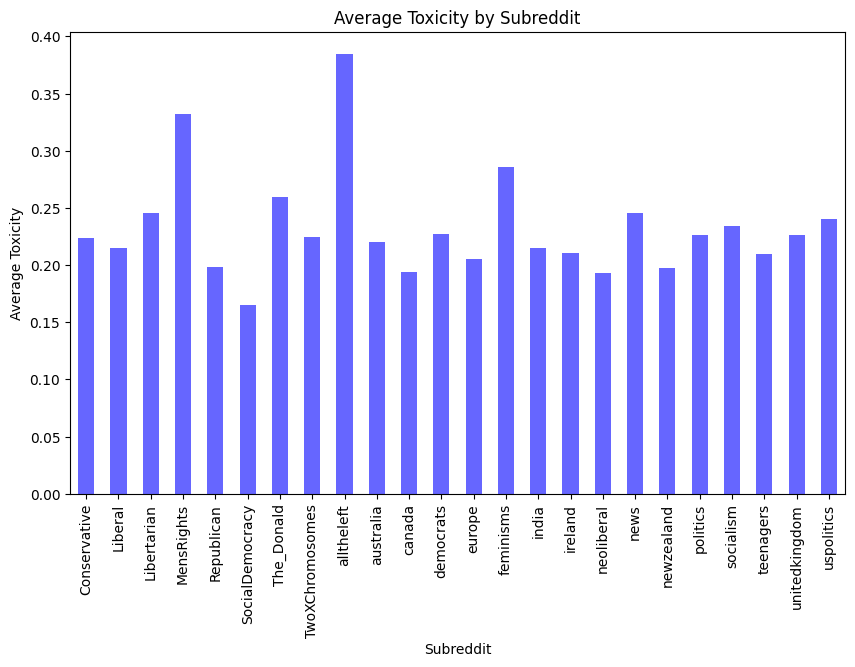

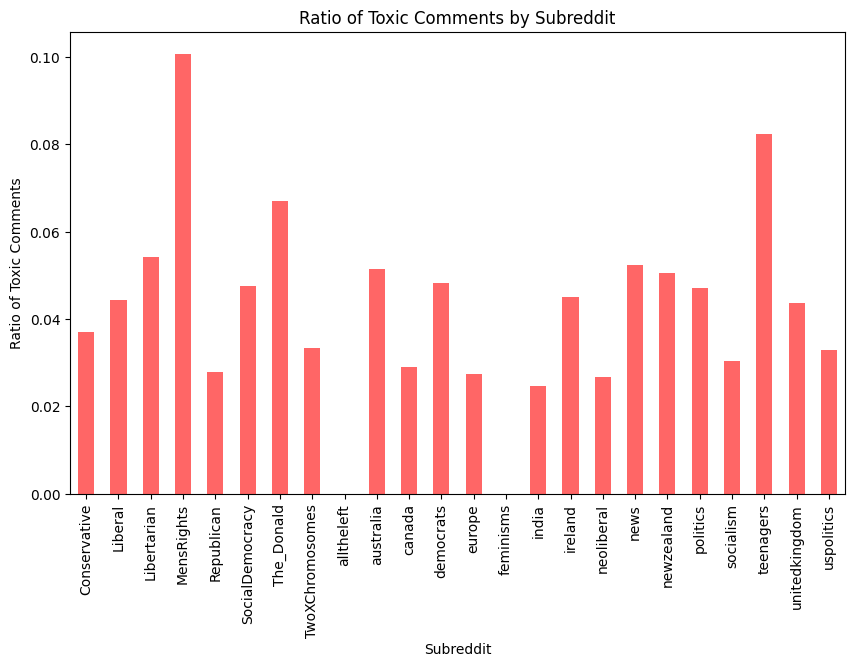

,avg_toxicity,toxic_count,total_count,toxic_ratio
subreddit,,,,
Conservative,0.223620,75,2021,0.037110
Liberal,0.214883,4,90,0.044444
Libertarian,0.245704,113,2088,0.054119
MensRights,0.332158,14,139,0.100719
Republican,0.198663,4,144,0.027778
SocialDemocracy,0.165206,1,21,0.047619
The_Donald,0.259530,1117,16689,0.066930
TwoXChromosomes,0.224859,5,150,0.033333
alltheleft,0.384721,0,4,0.000000


In [14]:
# Add a column to indicate if a comment is toxic based on the threshold of 0.7
df['is_toxic'] = df['toxicity'] > 0.7

# Calculate average toxicity and ratio of toxic comments across subreddits
subreddit_stats = df.groupby('subreddit').agg(
    avg_toxicity=('toxicity', 'mean'),
    toxic_count=('is_toxic', 'sum'),
    total_count=('id', 'count')
)

subreddit_stats['toxic_ratio'] = subreddit_stats['toxic_count'] / subreddit_stats['total_count']

# Plot average toxicity across subreddits
plt.figure(figsize=(10, 6))
subreddit_stats['avg_toxicity'].plot(kind='bar', color='blue', alpha=0.6)
plt.xlabel('Subreddit')
plt.ylabel('Average Toxicity')
plt.title('Average Toxicity by Subreddit')
plt.show()

# Plot ratio of toxic comments across subreddits
plt.figure(figsize=(10, 6))
subreddit_stats['toxic_ratio'].plot(kind='bar', color='red', alpha=0.6)
plt.xlabel('Subreddit')
plt.ylabel('Ratio of Toxic Comments')
plt.title('Ratio of Toxic Comments by Subreddit')
plt.show()

# Display the stats
subreddit_stats

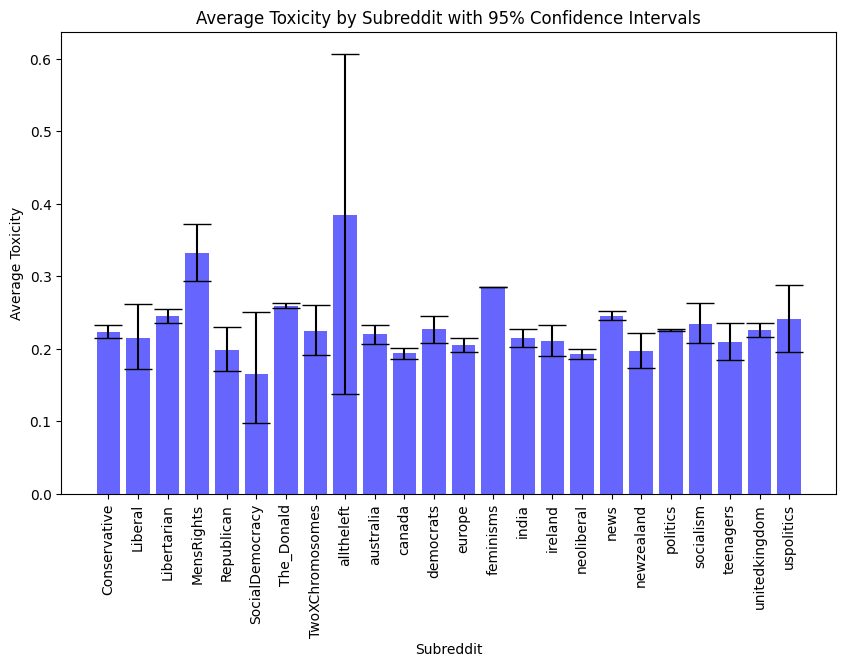

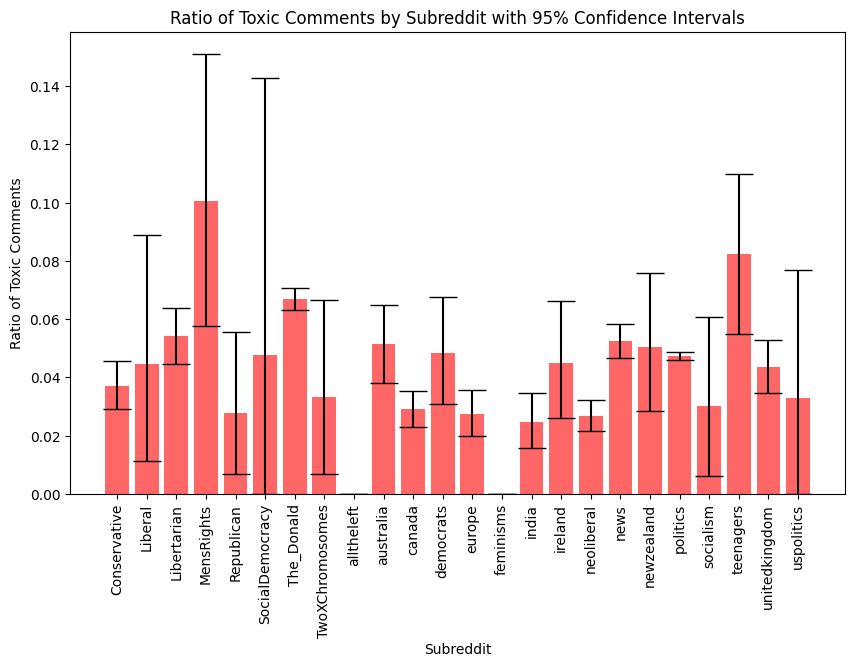

,avg_toxicity,toxic_count,total_count,toxic_ratio,avg_toxicity_ci_low,avg_toxicity_ci_high,toxic_ratio_ci_low,toxic_ratio_ci_high
subreddit,,,,,,,,
Conservative,0.223620,75,2021,0.037110,0.214764,0.232830,0.029193,0.045522
Liberal,0.214883,4,90,0.044444,0.172411,0.261484,0.011111,0.088889
Libertarian,0.245704,113,2088,0.054119,0.236331,0.255378,0.044540,0.063697
MensRights,0.332158,14,139,0.100719,0.293556,0.372170,0.057554,0.151079
Republican,0.198663,4,144,0.027778,0.168842,0.229531,0.006944,0.055556
SocialDemocracy,0.165206,1,21,0.047619,0.098311,0.250729,0.000000,0.142857
The_Donald,0.259530,1117,16689,0.066930,0.255983,0.263049,0.063095,0.070767
TwoXChromosomes,0.224859,5,150,0.033333,0.191459,0.260406,0.006667,0.066667
alltheleft,0.384721,0,4,0.000000,0.138218,0.606942,0.000000,0.000000


In [15]:
# Function to calculate bootstrap confidence intervals for means
def bootstrap_ci_mean(data, n_iterations=10000):
    bootstrapped_means = []
    for _ in range(n_iterations):
        resampled_data = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(resampled_data.mean())
    return np.percentile(bootstrapped_means, [2.5, 97.5])

# Calculate bootstrap confidence intervals for average toxicity by subreddit
subreddit_stats['avg_toxicity_ci_low'] = subreddit_stats.apply(
    lambda row: bootstrap_ci_mean(df[df['subreddit'] == row.name]['toxicity'])[0], axis=1)
subreddit_stats['avg_toxicity_ci_high'] = subreddit_stats.apply(
    lambda row: bootstrap_ci_mean(df[df['subreddit'] == row.name]['toxicity'])[1], axis=1)

# Calculate bootstrap confidence intervals for toxic ratio by subreddit
subreddit_stats['toxic_ratio_ci_low'] = subreddit_stats.apply(
    lambda row: bootstrap_ci_mean(df[df['subreddit'] == row.name]['is_toxic'].astype(float))[0], axis=1)
subreddit_stats['toxic_ratio_ci_high'] = subreddit_stats.apply(
    lambda row: bootstrap_ci_mean(df[df['subreddit'] == row.name]['is_toxic'].astype(float))[1], axis=1)


# Plot average toxicity across subreddits with confidence intervals (vertical x labels)
plt.figure(figsize=(10, 6))
plt.bar(subreddit_stats.index, subreddit_stats['avg_toxicity'], 
        yerr=[subreddit_stats['avg_toxicity'] - subreddit_stats['avg_toxicity_ci_low'], 
              subreddit_stats['avg_toxicity_ci_high'] - subreddit_stats['avg_toxicity']], 
        capsize=10, color='blue', alpha=0.6)
plt.xlabel('Subreddit')
plt.ylabel('Average Toxicity')
plt.title('Average Toxicity by Subreddit with 95% Confidence Intervals')
plt.xticks(rotation=90)
plt.show()

# Plot ratio of toxic comments across subreddits with confidence intervals (vertical x labels)
plt.figure(figsize=(10, 6))
plt.bar(subreddit_stats.index, subreddit_stats['toxic_ratio'], 
        yerr=[subreddit_stats['toxic_ratio'] - subreddit_stats['toxic_ratio_ci_low'], 
              subreddit_stats['toxic_ratio_ci_high'] - subreddit_stats['toxic_ratio']], 
        capsize=10, color='red', alpha=0.6)
plt.xlabel('Subreddit')
plt.ylabel('Ratio of Toxic Comments')
plt.title('Ratio of Toxic Comments by Subreddit with 95% Confidence Intervals')
plt.xticks(rotation=90)
plt.show()


# Display the updated stats with confidence intervals
subreddit_stats


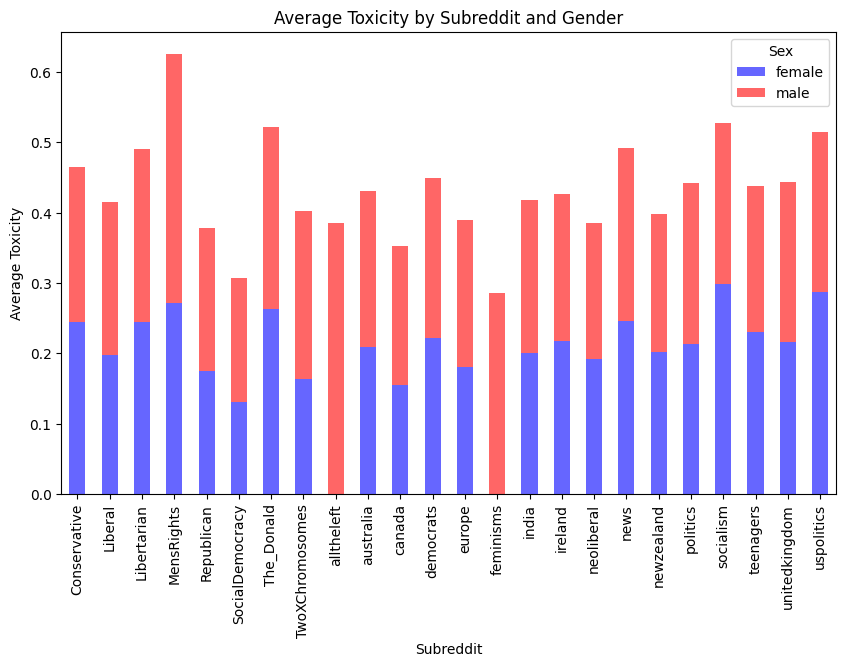

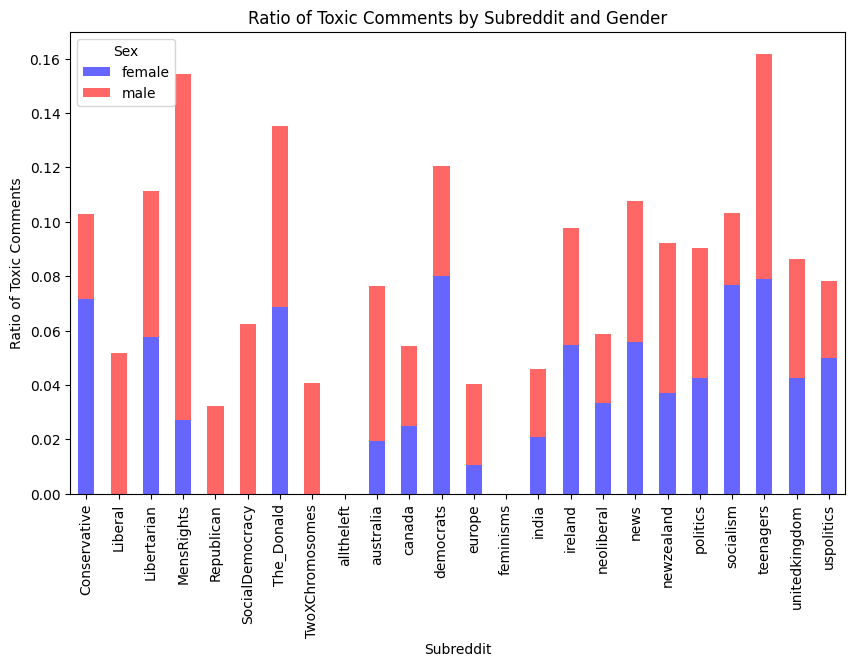

In [16]:
df_filtered = df[df['sex'].isin(['male', 'female'])]

# Calculate average toxicity and ratio of toxic comments across subreddits and genders
subreddit_gender_stats = df_filtered.groupby(['subreddit', 'sex']).agg(
    avg_toxicity=('toxicity', 'mean'),
    toxic_count=('is_toxic', 'sum'),
    total_count=('id', 'count')
).reset_index()

subreddit_gender_stats['toxic_ratio'] = subreddit_gender_stats['toxic_count'] / subreddit_gender_stats['total_count']

# Pivot the data for plotting
pivot_avg_toxicity = subreddit_gender_stats.pivot(index='subreddit', columns='sex', values='avg_toxicity')
pivot_toxic_ratio = subreddit_gender_stats.pivot(index='subreddit', columns='sex', values='toxic_ratio')

# Plot average toxicity across subreddits with gender separation
pivot_avg_toxicity.plot(kind='bar', stacked=True, figsize=(10, 6), color=['blue', 'red'], alpha=0.6)
plt.xlabel('Subreddit')
plt.ylabel('Average Toxicity')
plt.title('Average Toxicity by Subreddit and Gender')
plt.xticks(rotation=90)
plt.legend(title='Sex')
plt.show()

# Plot ratio of toxic comments across subreddits with gender separation
pivot_toxic_ratio.plot(kind='bar', stacked=True, figsize=(10, 6), color=['blue', 'red'], alpha=0.6)
plt.xlabel('Subreddit')
plt.ylabel('Ratio of Toxic Comments')
plt.title('Ratio of Toxic Comments by Subreddit and Gender')
plt.xticks(rotation=90)
plt.legend(title='Sex')
plt.show()

Subreddit gender stats columns after aggregation: Index(['subreddit', 'sex', 'avg_toxicity', 'toxic_count', 'total_count',
       'toxic_ratio'],
      dtype='object')


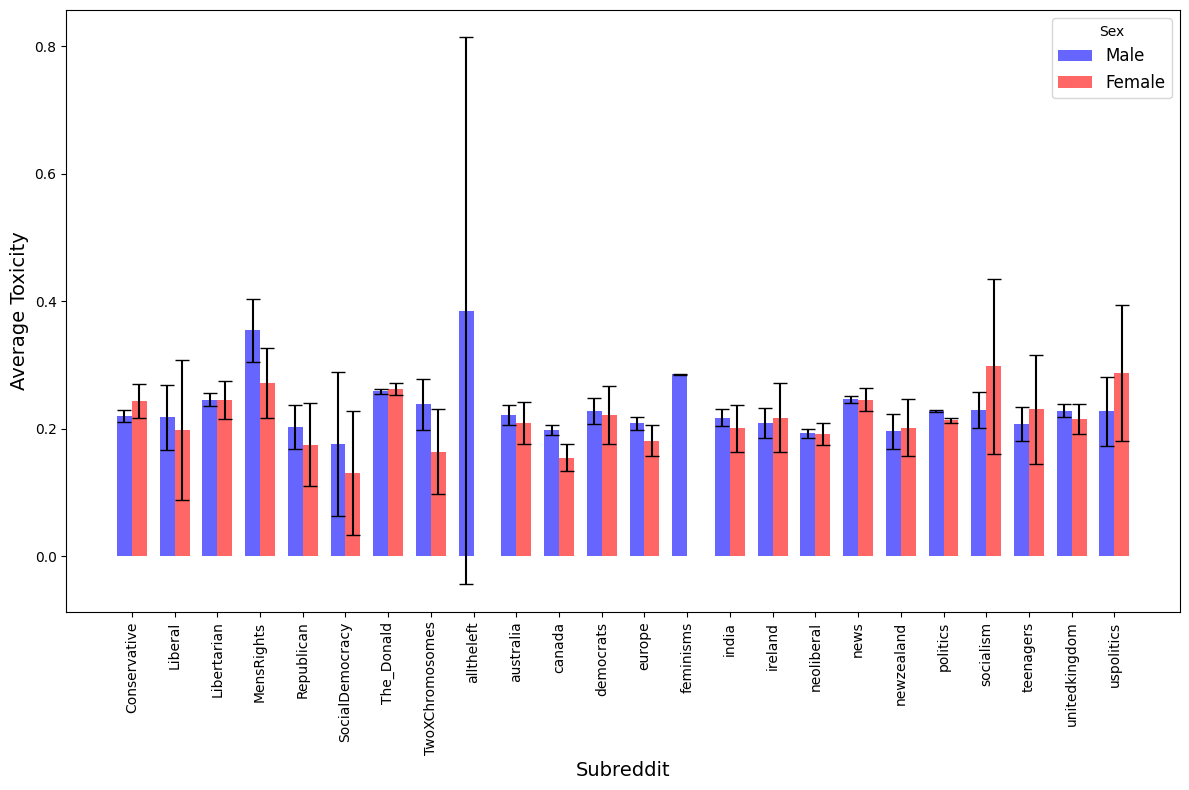

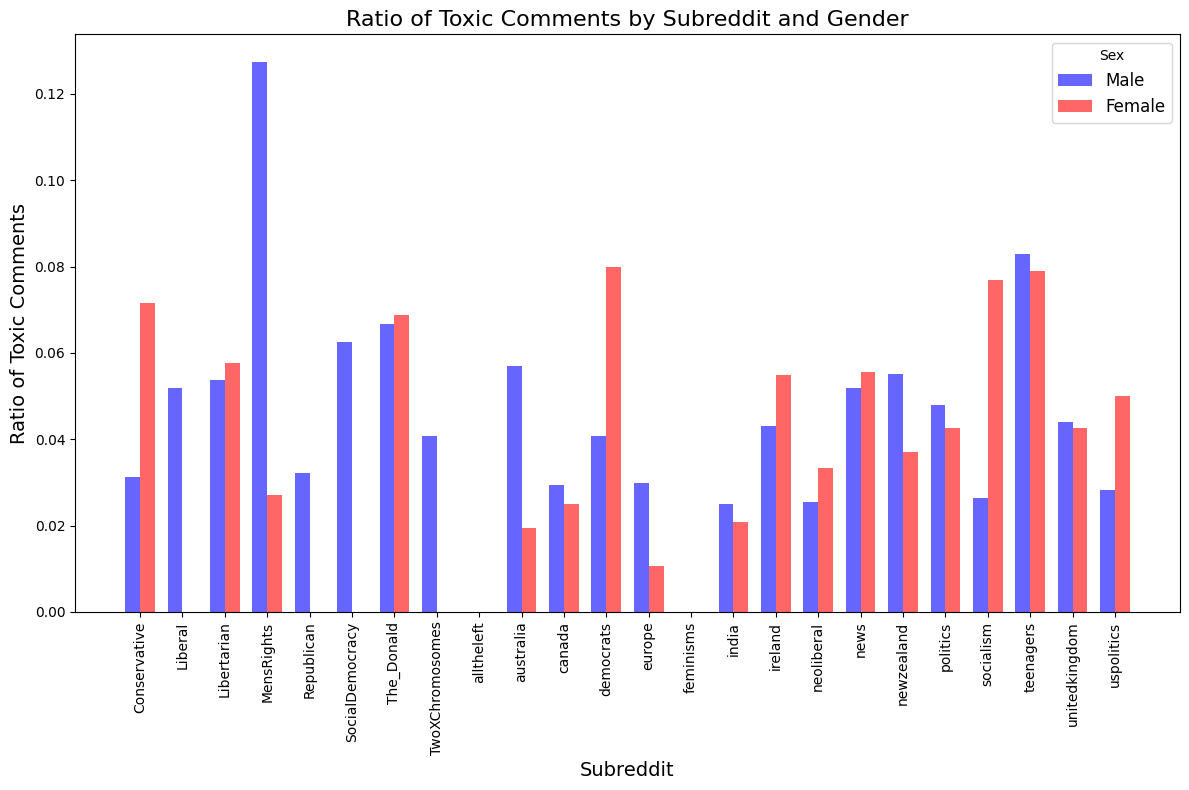

In [17]:
# Function to calculate the confidence interval
def compute_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, h

# Filter the data to include only male and female
df_filtered = df[df['sex'].isin(['male', 'female'])]

# Calculate average toxicity and ratio of toxic comments across subreddits and genders
subreddit_gender_stats = df_filtered.groupby(['subreddit', 'sex']).agg(
    avg_toxicity=('toxicity', 'mean'),
    toxic_count=('is_toxic', 'sum'),
    total_count=('id', 'count')
).reset_index()

subreddit_gender_stats['toxic_ratio'] = subreddit_gender_stats['toxic_count'] / subreddit_gender_stats['total_count']

# Print columns to debug
print("Subreddit gender stats columns after aggregation:", subreddit_gender_stats.columns)

# Calculate confidence intervals for average toxicity
ci = df_filtered.groupby(['subreddit', 'sex'])['toxicity'].apply(lambda x: compute_confidence_interval(x)).reset_index()
ci[['avg_toxicity', 'ci']] = pd.DataFrame(ci['toxicity'].tolist(), index=ci.index)
ci = ci.drop(columns='toxicity')

# Merge confidence intervals with the main stats
subreddit_gender_stats = pd.merge(subreddit_gender_stats, ci, on=['subreddit', 'sex'])


# Drop the duplicate 'avg_toxicity' column and keep the one from the confidence interval calculation
subreddit_gender_stats = subreddit_gender_stats.drop(columns=['avg_toxicity_x'])
subreddit_gender_stats = subreddit_gender_stats.rename(columns={'avg_toxicity_y': 'avg_toxicity'})


# Pivot the data for plotting
pivot_avg_toxicity = subreddit_gender_stats.pivot(index='subreddit', columns='sex', values='avg_toxicity')
pivot_ci = subreddit_gender_stats.pivot(index='subreddit', columns='sex', values='ci')
pivot_toxic_ratio = subreddit_gender_stats.pivot(index='subreddit', columns='sex', values='toxic_ratio')

# Plot average toxicity across subreddits with gender separation and confidence intervals
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(pivot_avg_toxicity))  # the label locations
width = 0.35  # the width of the bars

# Plotting male toxicity
ax.bar(x - width/2, pivot_avg_toxicity['male'], width, label='Male', 
       yerr=pivot_ci['male'], capsize=5, color='blue', alpha=0.6)

# Plotting female toxicity
ax.bar(x + width/2, pivot_avg_toxicity['female'], width, label='Female', 
       yerr=pivot_ci['female'], capsize=5, color='red', alpha=0.6)

# Add labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Subreddit', fontsize = 14)
ax.set_ylabel('Average Toxicity', fontsize = 14)
#ax.set_title('Average Toxicity by Subreddit and Gender with Confidence Intervals', fontsize = 16)
ax.set_xticks(x)
ax.set_xticklabels(pivot_avg_toxicity.index, rotation=90)
ax.legend(title='Sex', fontsize = 12)

fig.tight_layout()
plt.savefig("subreddit_toxicity.png")
plt.show()

# Plot ratio of toxic comments across subreddits with gender separation (no confidence intervals for ratio)
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting male toxic ratio
ax.bar(x - width/2, pivot_toxic_ratio['male'], width, label='Male', color='blue', alpha=0.6)

# Plotting female toxic ratio
ax.bar(x + width/2, pivot_toxic_ratio['female'], width, label='Female', color='red', alpha=0.6)

# Add labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Subreddit', fontsize = 14)
ax.set_ylabel('Ratio of Toxic Comments', fontsize = 14)
ax.set_title('Ratio of Toxic Comments by Subreddit and Gender', fontsize = 16)
ax.set_xticks(x)
ax.set_xticklabels(pivot_toxic_ratio.index, rotation=90)
ax.legend(title='Sex', fontsize = 12)

fig.tight_layout()
plt.show()



In [18]:
subreddit_gender_stats

,subreddit,sex,toxic_count,total_count,toxic_ratio,avg_toxicity,ci
0,Conservative,female,21,293,0.071672,0.244008,0.026640
1,Conservative,male,54,1728,0.031250,0.220162,0.009486
2,Liberal,female,0,13,0.000000,0.197971,0.109372
3,Liberal,male,4,77,0.051948,0.217738,0.050451
4,Libertarian,female,13,225,0.057778,0.244784,0.029828
5,Libertarian,male,100,1863,0.053677,0.245815,0.010173
6,MensRights,female,1,37,0.027027,0.271629,0.054808
7,MensRights,male,13,102,0.127451,0.354114,0.049672
8,Republican,female,0,20,0.000000,0.174990,0.065290
9,Republican,male,4,124,0.032258,0.202481,0.034401


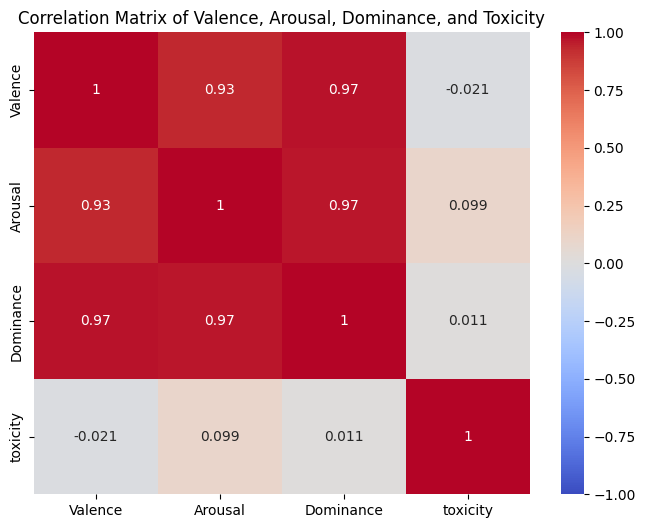

In [19]:
# Select only the relevant columns for correlation
selected_columns = ['Valence', 'Arousal', 'Dominance', 'toxicity']
selected_df = df[selected_columns]

# Calculate the correlation matrix
corr_matrix = selected_df.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Valence, Arousal, Dominance, and Toxicity')
plt.show()